# Blackjack Simulator Analysis

This notebook analyzes the blackjack simulation data to determine optimal strategies for different game states.

## Data Structure
- **Dealer Shown Score**: 1-10 (ace to 10/face cards)
- **Player Score**: 2-20
- **Hand Categories**:
  - 0: Normal (hard hand, no ace)
  - 1: Has Ace (soft hand)
  - 2: Split Available (pair)
- **Actions**:
  - 0: Stand
  - 1: Hit
  - 2: Double
  - 3: Split

In [15]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load and Parse Data

In [16]:
# Load the simulation data
with open('../bj_sim_data.json', 'r') as f:
    sim_data = json.load(f)

print(f"Loaded data for {len(sim_data)} dealer scores")

Loaded data for 10 dealer scores


## Convert to DataFrame Format

We'll create a comprehensive dataset with all the information needed for analysis.

In [17]:
# Create a list to store all data rows
data_rows = []

# Action names for better readability
action_names = {0: 'Stand', 1: 'Hit', 2: 'Double', 3: 'Split'}
hand_cat_names = {0: 'Normal', 1: 'Has Ace', 2: 'Split Available'}

# Parse the nested JSON structure
for dealer_score_str, player_scores in sim_data.items():
    dealer_score = int(dealer_score_str)
    
    for player_score_str, hand_categories in player_scores.items():
        player_score = int(player_score_str)
        
        for hand_cat_str, actions in hand_categories.items():
            hand_cat = int(hand_cat_str)
            
            # Create a row with all action expected values
            row = {
                'dealerShownScore': dealer_score,
                'playerScore': player_score,
                'handCategory': hand_cat,
                'handCategoryName': hand_cat_names[hand_cat]
            }
            
            # Add expected values for each action
            non_zero_trials = False
            for action_str, data in actions.items():
                action = int(action_str)
                action_name = action_names[action]
                row[f'{action_name}_EV'] = data['ExpectedValue']
                row[f'{action_name}_Trials'] = data['Trials']
                if data['Trials'] > 0:
                    non_zero_trials = True
            
            
            # if all trials are zero, skip this row
            if not non_zero_trials:
                continue
            data_rows.append(row)

# Create DataFrame
df = pd.DataFrame(data_rows)

# Sort for better organization
df = df.sort_values(['handCategory', 'dealerShownScore', 'playerScore']).reset_index(drop=True)

print(f"Created dataset with {len(df)} rows")
print(f"\nColumns: {df.columns.tolist()}")
df.head(10)

Created dataset with 350 rows

Columns: ['dealerShownScore', 'playerScore', 'handCategory', 'handCategoryName', 'Stand_EV', 'Stand_Trials', 'Hit_EV', 'Hit_Trials', 'Double_EV', 'Double_Trials', 'Split_EV', 'Split_Trials']


,dealerShownScore,playerScore,handCategory,handCategoryName,Stand_EV,Stand_Trials,Hit_EV,Hit_Trials,Double_EV,Double_Trials,Split_EV,Split_Trials
0,1,5,0,Normal,-0.662967,1545573,-0.477718,1545573,-1.046901,1545573,NaN,NaN
1,1,6,0,Normal,-0.657907,1545288,-0.495972,1545288,-1.030358,1545288,NaN,NaN
2,1,7,0,Normal,-0.653217,3155271,-0.459241,3155271,-0.902956,3155271,NaN,NaN
3,1,8,0,Normal,-0.640942,3255276,-0.366182,3255276,-0.660786,3255276,NaN,NaN
4,1,9,0,Normal,-0.636670,4989430,-0.261601,4989430,-0.382698,4989430,NaN,NaN
5,1,10,0,Normal,-0.625832,5204235,-0.155025,5204235,-0.063258,5204235,NaN,NaN
6,1,11,0,Normal,-0.234458,10003720,-0.036335,10003720,0.138885,10003720,NaN,NaN
7,1,12,0,Normal,-0.611835,13427793,-0.542794,13427793,-0.872956,13427793,NaN,NaN
8,1,13,0,Normal,-0.605862,14632626,-0.592138,14632626,-0.966374,14632626,NaN,NaN
9,1,14,0,Normal,-0.602659,14199616,-0.642317,14199616,-1.031968,14199616,NaN,NaN


## Determine Best Action for Each State

For each game state, we'll identify which action has the highest expected value.

In [18]:
# Function to determine best action
def get_best_action(row):
    """Return the action with highest expected value"""
    # Get all action columns that are present
    actions_ev = {}
    for action_name in ['Stand', 'Hit', 'Double', 'Split']:
        col_name = f'{action_name}_EV'
        if col_name in row and pd.notna(row[col_name]):
            actions_ev[action_name] = row[col_name]
    
    if not actions_ev:
        return None, None
    
    best_action = max(actions_ev, key=actions_ev.get)
    best_value = actions_ev[best_action]
    
    return best_action, best_value

# Apply the function to each row
df[['bestAction', 'bestEV']] = df.apply(get_best_action, axis=1, result_type='expand')

# Map action names to numeric codes for heatmap
action_codes = {'Stand': 0, 'Hit': 1, 'Double': 2, 'Split': 3}
df['bestActionCode'] = df['bestAction'].map(action_codes)

print("Best action distribution:")
print(df['bestAction'].value_counts())
print(f"\nAverage best EV: {df['bestEV'].mean():.4f}")

Best action distribution:
bestAction
Hit       115
Stand     114
Double     62
Split      59
Name: count, dtype: int64

Average best EV: 0.0222


## Save Processed Data to CSV

In [19]:
# Save the full dataset
df.to_csv('blackjack_analysis_data.csv', index=False)
print("Saved full dataset to blackjack_analysis_data.csv")

# Also save a summary dataset with just the essentials
summary_df = df[['dealerShownScore', 'playerScore', 'handCategory', 'handCategoryName', 
                  'Stand_EV', 'Hit_EV', 'Double_EV', 'Split_EV', 'bestAction', 'bestEV']].copy()
summary_df.to_csv('blackjack_summary.csv', index=False)
print("Saved summary dataset to blackjack_summary.csv")

Saved full dataset to blackjack_analysis_data.csv
Saved summary dataset to blackjack_summary.csv


## Generate Strategy Heatmaps

We'll create three heatmaps, one for each hand category:
1. **Normal Hand** (no ace)
2. **Soft Hand** (has ace)
3. **Split Available** (pair)

In [20]:
def create_strategy_heatmap(hand_category, hand_category_name):
    """Create a heatmap showing the best action for each dealer/player score combination"""
    
    # Filter data for this hand category
    cat_df = df[df['handCategory'] == hand_category].copy()
    
    if len(cat_df) == 0:
        print(f"No data for hand category {hand_category_name}")
        return
    
    # Create pivot table: rows=playerScore, cols=dealerScore, values=bestActionCode
    pivot = cat_df.pivot_table(
        index='playerScore',
        columns='dealerShownScore',
        values='bestActionCode',
        aggfunc='first'
    )
    
    # Sort for better visualization
    pivot = pivot.sort_index(ascending=False)  # Higher scores at top
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Define colors for each action
    colors = ['#4ECDC4', '#FF6B6B', '#FFE66D', '#95E1D3']  # Stand, Hit, Double, Split
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    # Create heatmap
    im = ax.imshow(pivot.values, cmap=cmap, norm=norm, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_xticklabels(pivot.columns, fontsize=14)
    ax.set_yticklabels(pivot.index, fontsize=14)
    
    # Add text annotations
    action_labels = ['S', 'H', 'D', 'P']  # Stand, Hit, Double, Split (short labels)
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            value = pivot.iloc[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, action_labels[int(value)],
                             ha="center", va="center", color="black", fontsize=14, fontweight='bold')
    
    # Labels and title
    ax.set_xlabel('Dealer Shown Score', fontsize=20, fontweight='bold')
    ax.set_ylabel('Player Score', fontsize=20, fontweight='bold')
    ax.set_title(f'Optimal Blackjack Strategy - {hand_category_name}', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors[0], label='Stand (S)'),
        Patch(facecolor=colors[1], label='Hit (H)'),
        Patch(facecolor=colors[2], label='Double (D)'),
        Patch(facecolor=colors[3], label='Split (P)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), 
             fontsize=13, frameon=True)
    
    plt.tight_layout()
    
    # Save figure
    filename = f'strategy_heatmap_{hand_category}_{hand_category_name.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved {filename}")
    
    plt.show()
    
    # Return statistics
    print(f"\n{hand_category_name} Statistics:")
    print(f"  Total states: {len(cat_df)}")
    print(f"  Action distribution:")
    for action, count in cat_df['bestAction'].value_counts().items():
        print(f"    {action}: {count} ({count/len(cat_df)*100:.1f}%)")
    print(f"  Average best EV: {cat_df['bestEV'].mean():.4f}")
    print()

### Heatmap 1: Normal Hand (Hard Hand, No Ace)

Saved strategy_heatmap_0_normal_hand.png


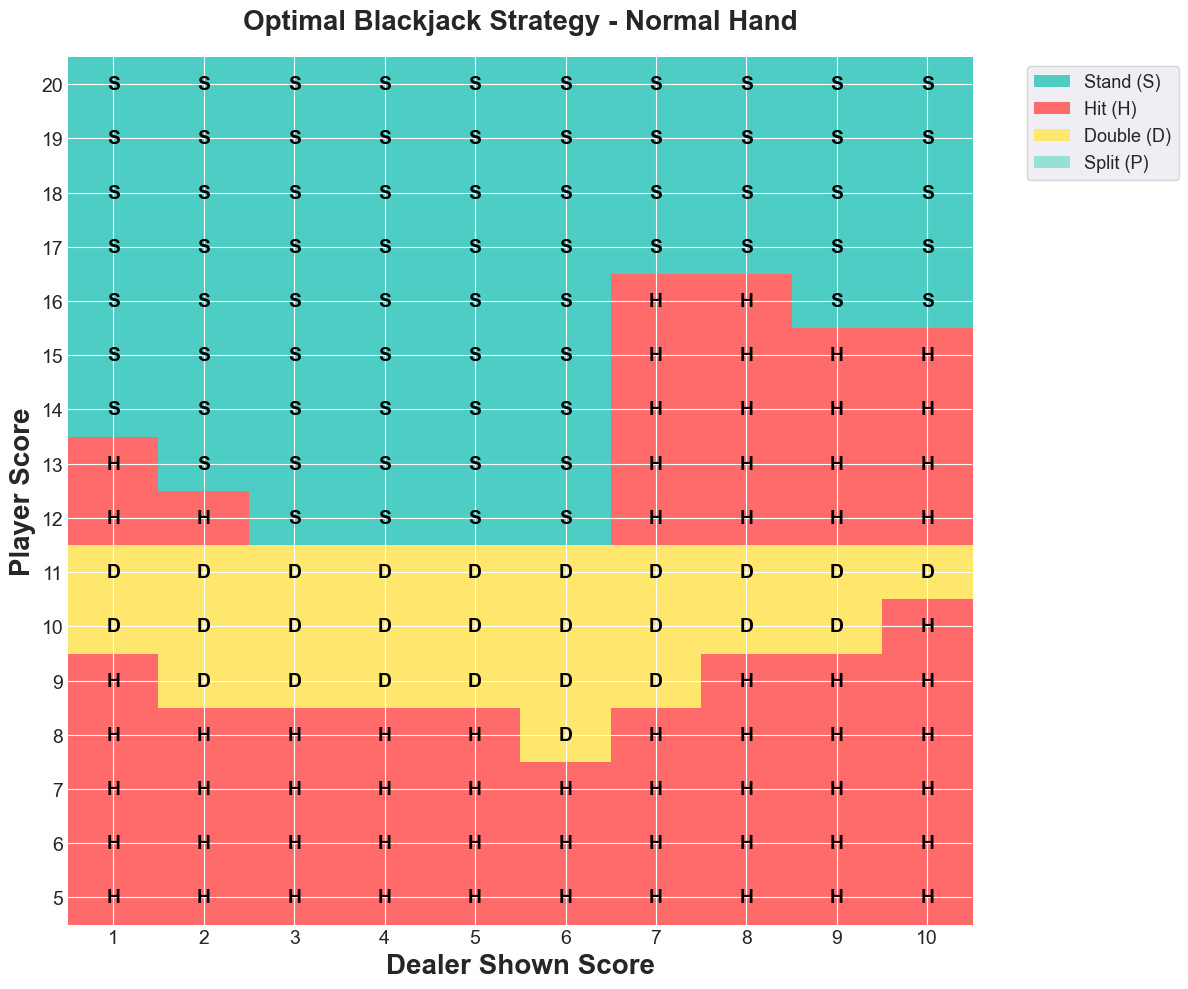


Normal Hand Statistics:
  Total states: 160
  Action distribution:
    Stand: 69 (43.1%)
    Hit: 65 (40.6%)
    Double: 26 (16.2%)
  Average best EV: -0.1216



In [31]:
create_strategy_heatmap(0, 'Normal Hand')

### Heatmap 2: Soft Hand (Has Ace)

Saved strategy_heatmap_1_soft_hand_(ace).png


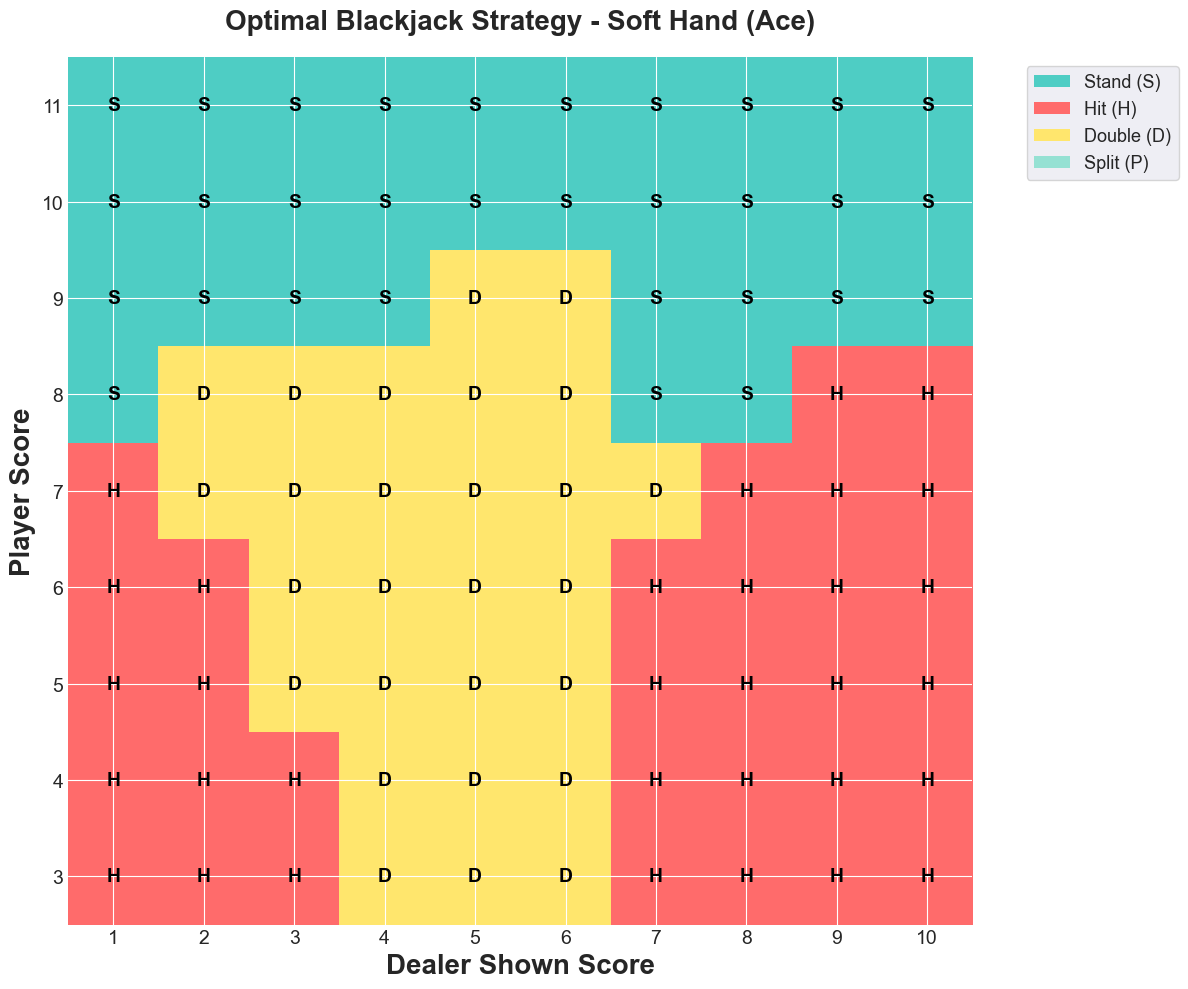


Soft Hand (Ace) Statistics:
  Total states: 90
  Action distribution:
    Hit: 32 (35.6%)
    Stand: 31 (34.4%)
    Double: 27 (30.0%)
  Average best EV: 0.1375



In [30]:
create_strategy_heatmap(1, 'Soft Hand (Ace)')

### Heatmap 3: Pair/Split Available

Saved strategy_heatmap_2_pair_(split_available).png


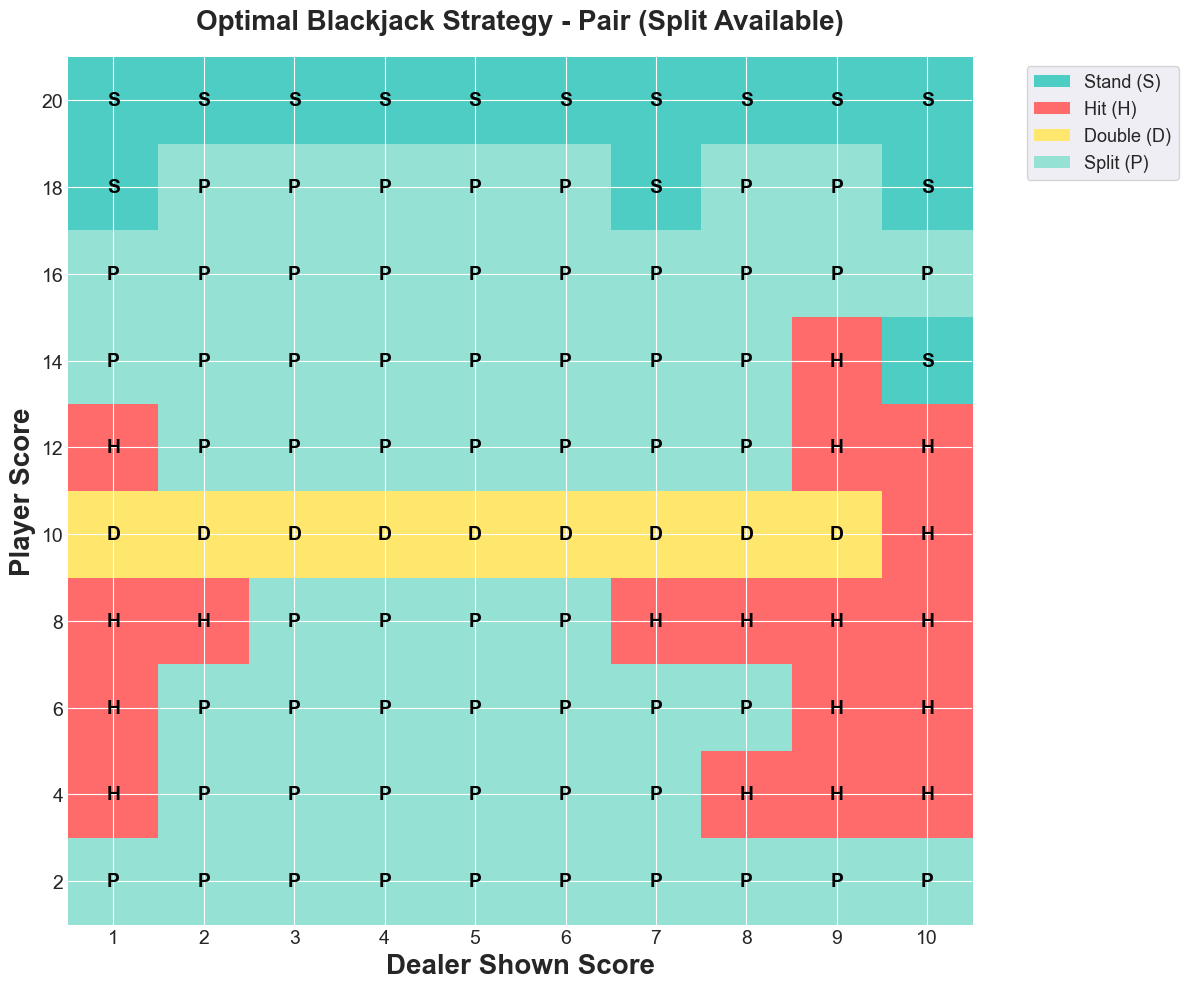


Pair (Split Available) Statistics:
  Total states: 100
  Action distribution:
    Split: 59 (59.0%)
    Hit: 18 (18.0%)
    Stand: 14 (14.0%)
    Double: 9 (9.0%)
  Average best EV: 0.1487



In [29]:
create_strategy_heatmap(2, 'Pair (Split Available)')

## Key Findings

Let's extract some key insights from the data.

In [24]:
print("=" * 70)
print("BLACKJACK STRATEGY ANALYSIS - KEY FINDINGS")
print("=" * 70)

# Overall statistics
print("\n1. OVERALL STATISTICS")
print("-" * 70)
print(f"Total game states analyzed: {len(df)}")
print(f"\nAction distribution across all states:")
for action, count in df['bestAction'].value_counts().items():
    print(f"  {action}: {count} states ({count/len(df)*100:.1f}%)")

print(f"\nExpected Value Statistics:")
print(f"  Overall average EV: {df['bestEV'].mean():.4f}")
print(f"  Best possible EV: {df['bestEV'].max():.4f}")
print(f"  Worst EV: {df['bestEV'].min():.4f}")

# Find the most profitable situations
print("\n2. MOST PROFITABLE SITUATIONS (Top 5)")
print("-" * 70)
top_situations = df.nlargest(5, 'bestEV')[['playerScore', 'dealerShownScore', 'handCategoryName', 'bestAction', 'bestEV']]
for idx, row in top_situations.iterrows():
    print(f"  Player: {row['playerScore']}, Dealer: {row['dealerShownScore']}, "
          f"Hand: {row['handCategoryName']}, Action: {row['bestAction']}, EV: {row['bestEV']:.4f}")

# Find the worst situations
print("\n3. WORST SITUATIONS (Bottom 5)")
print("-" * 70)
worst_situations = df.nsmallest(5, 'bestEV')[['playerScore', 'dealerShownScore', 'handCategoryName', 'bestAction', 'bestEV']]
for idx, row in worst_situations.iterrows():
    print(f"  Player: {row['playerScore']}, Dealer: {row['dealerShownScore']}, "
          f"Hand: {row['handCategoryName']}, Action: {row['bestAction']}, EV: {row['bestEV']:.4f}")

# Per hand category analysis
print("\n4. ANALYSIS BY HAND CATEGORY")
print("-" * 70)
for hand_cat in [0, 1, 2]:
    cat_name = hand_cat_names[hand_cat]
    cat_df = df[df['handCategory'] == hand_cat]
    if len(cat_df) > 0:
        print(f"\n{cat_name}:")
        print(f"  States: {len(cat_df)}")
        print(f"  Average EV: {cat_df['bestEV'].mean():.4f}")
        print(f"  Best action distribution:")
        for action, count in cat_df['bestAction'].value_counts().items():
            print(f"    {action}: {count/len(cat_df)*100:.1f}%")

# Dealer impact
print("\n5. DEALER SCORE IMPACT")
print("-" * 70)
dealer_impact = df.groupby('dealerShownScore')['bestEV'].mean().sort_values()
print("Average EV by dealer shown score (worst to best for player):")
for dealer_score, avg_ev in dealer_impact.items():
    print(f"  Dealer shows {dealer_score}: {avg_ev:.4f}")

print("\n" + "=" * 70)

BLACKJACK STRATEGY ANALYSIS - KEY FINDINGS

1. OVERALL STATISTICS
----------------------------------------------------------------------
Total game states analyzed: 350

Action distribution across all states:
  Hit: 115 states (32.9%)
  Stand: 114 states (32.6%)
  Double: 62 states (17.7%)
  Split: 59 states (16.9%)

Expected Value Statistics:
  Overall average EV: 0.0222
  Best possible EV: 1.1177
  Worst EV: -0.7121

2. MOST PROFITABLE SITUATIONS (Top 5)
----------------------------------------------------------------------
  Player: 2, Dealer: 6, Hand: Split Available, Action: Split, EV: 1.1177
  Player: 2, Dealer: 5, Hand: Split Available, Action: Split, EV: 1.0012
  Player: 2, Dealer: 4, Hand: Split Available, Action: Split, EV: 0.8654
  Player: 11, Dealer: 6, Hand: Has Ace, Action: Stand, EV: 0.8291
  Player: 11, Dealer: 5, Hand: Has Ace, Action: Stand, EV: 0.8153

3. WORST SITUATIONS (Bottom 5)
----------------------------------------------------------------------
  Player: 16, 

In [28]:
df['Stand_Trials'].sum() + df['Hit_Trials'].sum() + df['Double_Trials'].sum() + df['Split_Trials'].sum()

np.float64(7985265908.0)

## Additional Visualizations

Saved ev_distributions.png


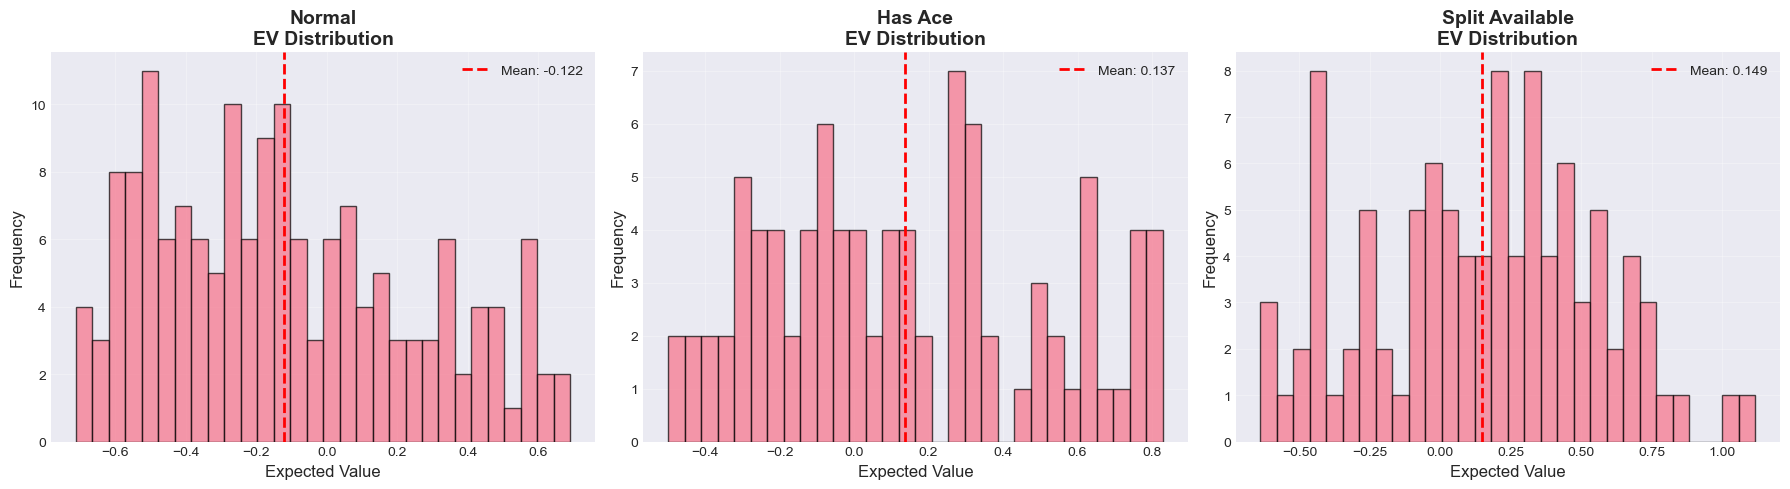

In [25]:
# Expected Value distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, hand_cat in enumerate([0, 1, 2]):
    cat_name = hand_cat_names[hand_cat]
    cat_df = df[df['handCategory'] == hand_cat]
    
    if len(cat_df) > 0:
        axes[idx].hist(cat_df['bestEV'], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].axvline(cat_df['bestEV'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cat_df["bestEV"].mean():.3f}')
        axes[idx].set_xlabel('Expected Value', fontsize=12)
        axes[idx].set_ylabel('Frequency', fontsize=12)
        axes[idx].set_title(f'{cat_name}\nEV Distribution', fontsize=14, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ev_distributions.png', dpi=300, bbox_inches='tight')
print("Saved ev_distributions.png")
plt.show()

Saved action_distribution.png


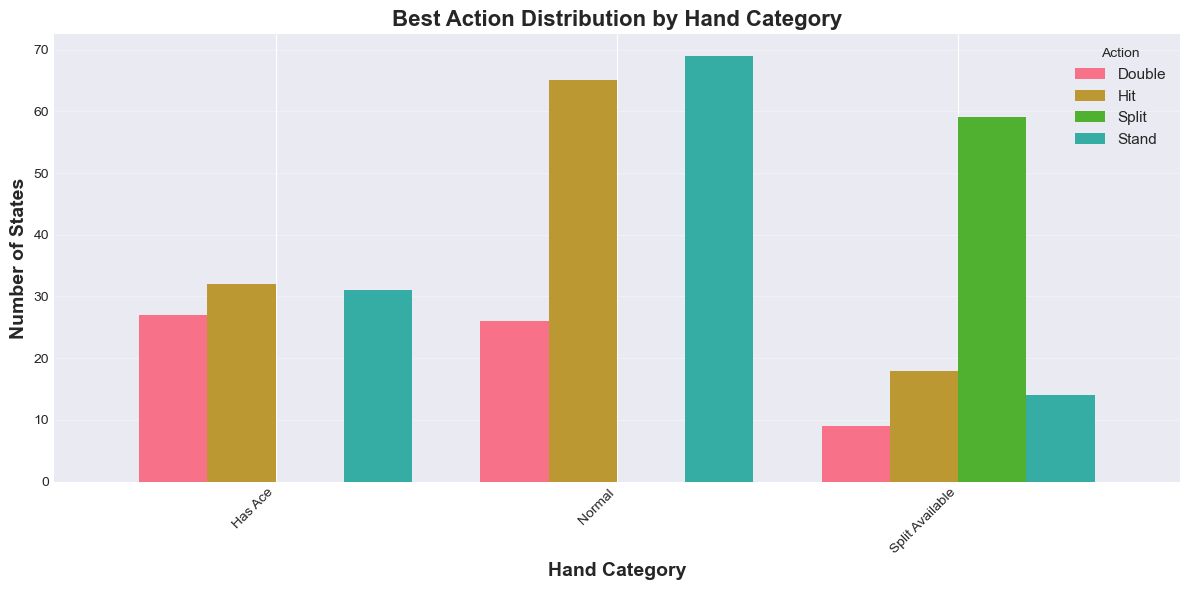

In [26]:
# Action distribution by hand category
fig, ax = plt.subplots(figsize=(12, 6))

action_data = []
for hand_cat in [0, 1, 2]:
    cat_name = hand_cat_names[hand_cat]
    cat_df = df[df['handCategory'] == hand_cat]
    if len(cat_df) > 0:
        for action in ['Stand', 'Hit', 'Double', 'Split']:
            count = (cat_df['bestAction'] == action).sum()
            action_data.append({
                'Hand Category': cat_name,
                'Action': action,
                'Count': count
            })

action_df = pd.DataFrame(action_data)
action_pivot = action_df.pivot(index='Hand Category', columns='Action', values='Count')
action_pivot.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Hand Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of States', fontsize=14, fontweight='bold')
ax.set_title('Best Action Distribution by Hand Category', fontsize=16, fontweight='bold')
ax.legend(title='Action', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('action_distribution.png', dpi=300, bbox_inches='tight')
print("Saved action_distribution.png")
plt.show()

## Conclusion

This analysis provides a comprehensive view of optimal blackjack strategy based on simulation data. The heatmaps show the best action for every possible game state, categorized by hand type. The key findings reveal which situations are most favorable for the player and how strategy should vary based on the dealer's shown card and the type of hand you're holding.